In [99]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from scipy.stats import qmc
from tqdm import tqdm
import random
from IPython.display import display

In [100]:
df = pd.read_csv('/Volumes/GoogleDrive-116698033185964814580/My Drive/Socialz/cobol_pullrequests.csv', usecols=['login', 'name'])
# Add user (u: ) repo (r: ) indicator for each node
df['login'] = df['login'].apply(lambda x: 'u: '+x)
df['name'] = df['name'].apply(lambda x: 'r: '+x)

df

,login,name
0,u: vim-sroberge,r: vimaec/g3d
1,u: vim-sroberge,r: vimaec/g3d
2,u: vim-sroberge,r: vimaec/g3d
3,u: vim-sroberge,r: vimaec/g3d
4,u: mavimaec,r: vimaec/g3d
...,...,...
1328,u: joe-tingsanchali-sonarsource,r: SonarSource/sonar-scanning-examples
1329,u: joe-tingsanchali-sonarsource,r: SonarSource/sonar-scanning-examples
1330,u: joe-tingsanchali-sonarsource,r: SonarSource/sonar-scanning-examples
1331,u: joe-tingsanchali-sonarsource,r: SonarSource/sonar-scanning-examples


In [101]:
# Build the adjacency matrix for user - repo (and repo - user) interactions.
adj_matrix = pd.crosstab(df['login'], df['name']).astype(float)
idx = adj_matrix.columns.union(adj_matrix.index)
adj_matrix = adj_matrix.reindex(index = idx, columns=idx, fill_value=0.0)

adj_matrix

,r: AkinJimoh/aj-soner,r: AkinJimoh/sonar-scan,r: CPWRGIT/HDDRXM0,r: CPWRGIT/HDDRXM02,r: CPWRGIT/HDDRXM0_CWC2,r: CPWRGIT/ISPWSA0,r: CPWRGIT/ISPWSA0_CWC2,r: Compuware-Corp/TotalTest-Test-Repo,r: DhineshPalanisamy/FintechAPP,r: Dxngaa/print-dxngaa,...,u: turboKittyNinja,u: ursinn,u: velivalab,u: vim-sroberge,u: waitesid,u: whitesource-bolt-for-github[bot],u: wilbertkho,u: willdoescode,u: writ3it,u: yyyxam
r: AkinJimoh/aj-soner,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
r: AkinJimoh/sonar-scan,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
r: CPWRGIT/HDDRXM0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
r: CPWRGIT/HDDRXM02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
r: CPWRGIT/HDDRXM0_CWC2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
u: whitesource-bolt-for-github[bot],0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
u: wilbertkho,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
u: willdoescode,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
u: writ3it,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [102]:
# List user and repos
users = [x for x in adj_matrix.columns if x.startswith('u: ')]
repos = [x for x in adj_matrix.columns if x.startswith('r: ')]

print(f'Number of users: {len(users)}, number of repos: {len(repos)}')
G = nx.from_pandas_adjacency(adj_matrix, create_using=nx.DiGraph)
print(f'Directed graph with {nx.number_of_nodes(G)} nodes, {nx.number_of_edges(G)} edges and {nx.number_weakly_connected_components(G)} components')

Number of users: 145, number of repos: 117
Directed graph with 262 nodes, 192 edges and 74 components


In [103]:
def user_user_similarity(adj_matrix, repos):

    ## Get repo - user similarity (upper-right square):
    repo_user = adj_matrix.iloc[:len(repos),len(repos):]
    repo_user = repo_user/np.linalg.norm(repo_user,axis=0,keepdims=True)
    repo_user[np.isnan(repo_user)] = 0
    repo_user = np.dot(repo_user.transpose(),repo_user)

    ## Get user - repo similarity (lower-left square):
    user_repo = adj_matrix.iloc[len(repos):,:len(repos)]
    user_repo = user_repo/np.linalg.norm(user_repo,axis=1,keepdims=True)
    user_repo[np.isnan(user_repo)] = 0
    user_repo = np.dot(user_repo, user_repo.transpose())

    # Combine upper and lower triangles, keep 0 in the diagonal.
    user_user = np.triu(repo_user,1) + np.tril(user_repo,-1)

    # return user_user
    return user_user 

adj_matrix.loc[users, users] = user_user_similarity(adj_matrix, repos)
G = nx.from_pandas_adjacency(adj_matrix, create_using=nx.DiGraph)
print(f'Directed graph with {nx.number_of_nodes(G)} nodes, {nx.number_of_edges(G)} edges and {nx.number_weakly_connected_components(G)} components')

Directed graph with 262 nodes, 519 edges and 74 components


In [104]:
def mutate_vector(user_vect, max_value):
    # Set a random zero value to non-zero, one at a time.
    random = np.random.randint(0,len(user_vect))

    if 0 in user_vect.to_list():
        while user_vect.iloc[random] != 0:
            random = np.random.randint(0,len(user_vect))
        user_vect.iloc[random] = np.random.randint(1,max_value) # A value between 1 and max value


    # And, with 50% chance, sets a non-zero value to 0 or add random noise.
    chance = np.random.uniform(0,1)
    random = np.random.randint(0,len(user_vect))

    if not all(user_vect == 0):
        while user_vect.iloc[random] == 0:
            random = np.random.randint(0,len(user_vect))

        if chance > 0.5:
            # Add noise
            user_vect.iloc[random] = np.clip(user_vect.iloc[random] + np.random.choice([-1,1]) * np.random.randint(1,max_value),1,max_value)
        else:
            # Set to zero
            user_vect.iloc[random] = 0

    return user_vect

In [105]:
# Christoph variation, mutating single contributions, i.e., changing numbers by adding or subtracting 1 (but not have negative numbers)

def mutate_vector(user_vect, max_value):
    # Set a random zero value to non-zero, one at a time.
    random = np.random.randint(0,len(user_vect))

    user_vect.iloc[random] = np.clip(user_vect.iloc[random] + np.random.choice([-1,1]),0,max_value)

    return user_vect

In [106]:
# Mutator, give it an adj_matrix, and it will return the mutated adj_matrix.

def mutate(adj_matrix, node, repos, users):

  # Create copies of adj_matrix and user node:
  am          = adj_matrix.copy()
  user_index  = am.loc[node][:len(repos)]
  user_column = am.loc[:,node][:len(repos)]

  # Mutate user node:
  max_value = am.max().max()
  am.loc[node][:len(repos)]   = mutate_vector(user_index, max_value)
  am.loc[:,node][:len(repos)] = mutate_vector(user_column, max_value)

  # Evaluate similarity:
  am.loc[users, users] = user_user_similarity(am, repos)
  
  return am

In [159]:
# Compute graph metrics, betweenness centrality and node degree

def graph_metrics(adj_matrix, centrality):

     G = nx.from_pandas_adjacency(adj_matrix, create_using=nx.DiGraph)

     # nx.eigenvector_centrality
     if centrality == nx.eigenvector_centrality:
          centrality_column = 'eigenvector_centrality'
          result = None
          i = 500
          tol = 1.0e-6
          while result is None:
               try:
                    result = {'degree' : {node:val for (node, val) in G.degree()},
                              centrality_column: nx.eigenvector_centrality(G, max_iter=i, tol=tol)}
               except nx.exception.PowerIterationFailedConvergence:
                    i += 500
                    if i > 10000:
                         tol = 1.0e-5

     # nx.katz_centrality:
     if centrality == nx.katz_centrality:
          centrality_column = 'katz_centrality'
          result = None
          i = 1000
          tol = 1.0e-6
          while result is None:
               try:
                    result = {'degree' : {node:val for (node, val) in G.degree()} ,
                              centrality_column : centrality(G,normalized=False,max_iter=i,tol=tol)}
               except nx.exception.PowerIterationFailedConvergence:
                    i += 500
                    if i > 10000:
                         tol = 1.0e-5

     # nx.pagerank:
     if centrality == nx.pagerank:
          centrality_column = 'pagerank'
          result = {'degree' : {node:val for (node, val) in G.degree()} ,
                    centrality_column : centrality(G)}

     # nx.betweenness_centrality
     if centrality == nx.betweenness_centrality:
          centrality_column = 'betweenness_centrality'
          result = {'degree' : {node:val for (node, val) in G.degree()} ,
                    centrality_column : centrality(G,normalized=False)}

     # nx.degree_centrality
     if centrality == nx.degree_centrality:
          centrality_column = 'degree_centrality'
          s = 1.0 / (len(G) - 1.0)
          result = nx.degree_centrality(G)
          result = {k: v/s for k,v in result.items()} # undo normalisation
          result = {centrality_column:result}
          aux = {'degree' : {node:val for (node, val) in G.degree()}}
          result = aux | result # merge dicts

     # nx.closeness_centrality
     if centrality == nx.closeness_centrality:
          centrality_column = 'closeness_centrality'
          result = {'degree' : {node:val for (node, val) in G.degree()} ,
                    centrality_column:nx.closeness_centrality(G, wf_improved=False)}

     # Dict to DataFrame, normalise values
     # normalise node degree values  https://www.statology.org/normalize-data-between-0-and-1/
     # zi = (xi – min(x)) / (max(x) – min(x))
     result = pd.DataFrame(result)
     result['degree'] = result['degree'].apply(lambda x: (x - result['degree'].min())/(result['degree'].max() - result['degree'].min()))
     result[centrality_column] = result[centrality_column].apply(lambda x: (x - result[centrality_column].min())/(result[centrality_column].max() - result[centrality_column].min()))

     # filter users
     result = result[result.index.str.startswith('u: ')]

     return result

In [108]:
# Evaluate metrics in terms of star-discrepancy

def objective(candidate):
  return qmc.discrepancy(candidate, method='L2-star',workers=-1)

In [109]:
# evolution strategy (mu, lambda) algorithm

def es_plus(initial_record, objective, n_iter, mu, lam, centrality):
  best, best_eval = None, 1e+10

  # number of repos and users:
  users = [x for x in adj_matrix.columns if x.startswith('u: ')]
  repos = [x for x in adj_matrix.columns if x.startswith('r: ')]

	# calculate the number of children per parent
  n_children = int(lam / mu)
	
  # initial population
  population = list()
  
  for i in range(lam):
    candidate = initial_record.copy()       # copy the initial matrix
    population.append(candidate)            # add to population

  # perform the search
  for epoch in range(n_iter):
    # evaluate the fitness for the population
    scores = [objective(graph_metrics(candidate,centrality)) for candidate in population]
    # rank scores in ascending order
    ranks = np.argsort(np.argsort(scores))
    # select the indexes for the top mu ranked solutions, drop the worse results	
    selected = [i for i,_ in enumerate(ranks) if ranks[i] < mu]
    # create offspring from parents
    offspring = list()
    for i in selected:
      # check if this parent is the best solution ever seen
      if scores[i] < best_eval:
        best, best_eval, niter = population[i], scores[i], epoch
        #print('%d, Best eval: = %.5f' % (epoch, best_eval))
        
        # keep the parent
        offspring.append(population[i])

        # create offspring for parent
        for j in range(n_children):

          sample = np.random.choice(users)
          child = mutate(population[i], sample, repos, users)
          offspring.append(child)

    # replace population with children
    population = offspring

  return [niter, best, best_eval]

In [110]:
def plot_results(ax, user_node, bot_node, adj_matrix, metric):

    ax = ax or plt.gca()

    metric_df = graph_metrics(adj_matrix, metric)

    ax.scatter(metric_df.iloc[:,0],metric_df.iloc[:,1],edgecolor="k", c="r")
    ax.set_xlabel('Degree')
    ax.set_ylabel(str(metric).split(' ')[1])
    ax.annotate('mike', (metric_df.loc[user_node][0], metric_df.loc[user_node][1]))
    ax.annotate('bot', (metric_df.loc[bot_node][0] - 0.05, metric_df.loc[bot_node][1]- 0.05))
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])
    ax.text(0.5,-0.5,f'Star-discrepancy score: {objective(metric_df):.3f}',fontsize='large',horizontalalignment='center')
    plt.close()
    
    return ax

In [111]:
def plot_graph_comparison(initial_graph, final_graph, pos):

    d = {'Nodes':[nx.number_of_nodes(initial_graph),nx.number_of_nodes(final_graph)],
         'Edges':[nx.number_of_edges(initial_graph),nx.number_of_edges(final_graph)],
         'Components':[nx.number_weakly_connected_components(initial_graph), nx.number_weakly_connected_components(final_graph)]}

    display(pd.DataFrame(d, index=['G', 'N']))

    plt.figure(figsize=(10,5))
    plt.title('Initial Directed Graph G')

    plt.show()
    plt.close()
    plt.figure(figsize=(10,5))
    plt.title('Evolved Directed Graph N')
    color_map = ['b' if node.startswith('u: ') else 'y' for node in final_graph]
    nx.draw(final_graph, node_color=color_map, pos = pos)
    plt.show()
    plt.close()

In [112]:
def find_seed(n_seeds, adj_matrix, objective, n_iter, mu, lam, centrality):

    scores = {'seed':[],'iterations':[],'score':[],'nodes':[],'edges':[],'components':[]}

    for i in tqdm(range(n_seeds)):
        
        # set a seed
        np.random.seed(i)
        # define the total iterations
        n_iter = n_iter
        # number of parents selected
        mu = mu
        # the number of children generated by parents
        lam = lam
        # perform the evolution strategy (mu, lambda) search
        iterations, best, score = es_plus(adj_matrix, objective, n_iter, mu, lam, centrality)
        # compute the resulting graph
        N = nx.from_pandas_adjacency(best, create_using=nx.DiGraph)
        # get the number of nodes, edges and connected components
        nodes, edges, components = nx.number_of_nodes(N), nx.number_of_edges(N), nx.number_weakly_connected_components(N)

        scores['iterations'].append(iterations)
        scores['seed'].append(i)
        scores['score'].append(score)
        scores['nodes'].append(nodes)
        scores['edges'].append(edges)
        scores['components'].append(components)

    return pd.DataFrame(scores)

## Experimental results:
### (1 + 1)-EA, New mutation strategy

In [113]:
# (1 + 1) betweenness centrality evaluation:

seeds, n_iter, mu, lam, centrality = 100, 10000, 1, 1, nx.betweenness_centrality

scores = find_seed(seeds, adj_matrix, objective, n_iter, mu, lam, centrality)
scores.sort_values('score')

100%|██████████| 100/100 [00:23<00:00,  4.18it/s]


,seed,iterations,score,nodes,edges,components
82,82,14,0.629410,262,565,59
69,69,12,0.636435,262,550,57
47,47,9,0.638872,262,541,62
60,60,8,0.639670,262,532,64
44,44,8,0.640731,262,537,63
...,...,...,...,...,...,...
59,59,0,0.649914,262,519,74
23,23,0,0.649914,262,519,74
79,79,0,0.649914,262,519,74
28,28,0,0.649914,262,519,74


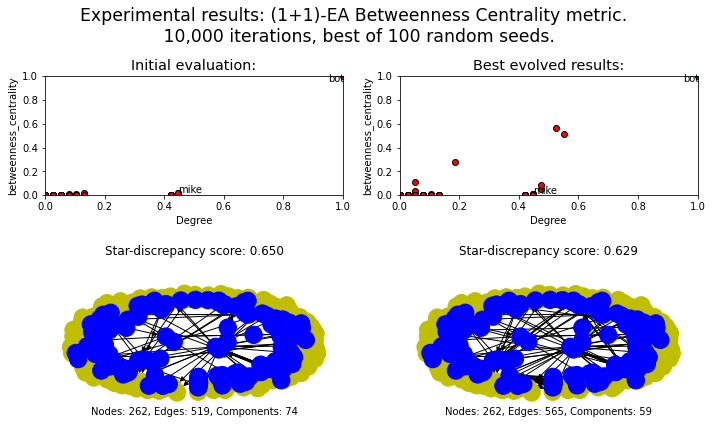

In [114]:
# set the best seed
np.random.seed(scores[scores['score'] == scores['score'].min()]['seed'])

# perform the evolution strategy (mu, lambda) search
iterations, best, score = es_plus(adj_matrix, objective, n_iter, mu, lam, centrality)

# Initial graph G
G = nx.from_pandas_adjacency(adj_matrix, create_using=nx.DiGraph)

# Optimised graph N
N = nx.from_pandas_adjacency(best, create_using=nx.DiGraph)

# plot results
fig1, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2,figsize=(10,6))
ax1.set_title('Initial evaluation:',fontsize='x-large')
ax2.set_title('Best evolved results:',fontsize='x-large')
plot_results(ax1,'u: mikeharrisontelia','u: dependabot[bot]', adj_matrix, centrality)
plot_results(ax2,'u: mikeharrisontelia','u: dependabot[bot]', best, centrality)
color_map = ['b' if node.startswith('u: ') else 'y' for node in G]
nx.draw(G, node_color=color_map, pos = pos, ax=ax3)
nx.draw(N, node_color=color_map, pos = pos, ax=ax4)
ax3.text(0.5,-0.1,f'Nodes: {nx.number_of_nodes(G)}, Edges: {nx.number_of_edges(G)}, Components: {nx.number_weakly_connected_components(G)}', ha='center', transform=ax3.transAxes)
ax4.text(0.5,-0.1,f'Nodes: {nx.number_of_nodes(N)}, Edges: {nx.number_of_edges(N)}, Components: {nx.number_weakly_connected_components(N)}', ha='center', transform=ax4.transAxes)
fig1.suptitle(f"Experimental results: ({lam}+{mu})-EA {str(centrality).split(' ')[1].replace('_', ' ').title()} metric. \n {n_iter:,} iterations, best of {seeds:,} random seeds.",fontsize='xx-large')
fig1.tight_layout()
fig1

In [115]:
# (1 + 1) closeness evaluation:

seeds, n_iter, mu, lam, centrality = 100, 10000, 1, 1, nx.closeness_centrality

scores = find_seed(seeds, adj_matrix, objective, n_iter, mu, lam, centrality)
scores.sort_values('score')

100%|██████████| 100/100 [00:18<00:00,  5.54it/s]


,seed,iterations,score,nodes,edges,components
46,46,7,0.304588,262,547,66
71,71,6,0.310495,262,532,68
77,77,7,0.315905,262,533,65
15,15,4,0.319068,262,528,69
10,10,4,0.319772,262,545,69
...,...,...,...,...,...,...
21,21,0,0.337715,262,519,74
22,22,0,0.337715,262,519,74
12,12,0,0.337715,262,519,74
80,80,0,0.337715,262,519,74


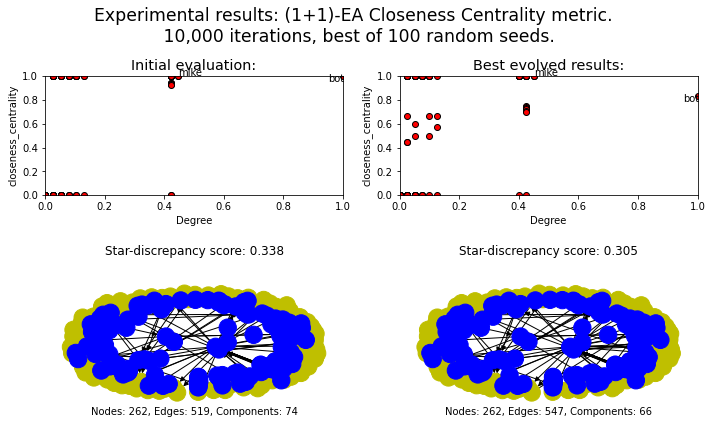

In [116]:
# set the best seed
np.random.seed(scores[scores['score'] == scores['score'].min()]['seed'])

# perform the evolution strategy (mu, lambda) search
iterations, best, score = es_plus(adj_matrix, objective, n_iter, mu, lam, centrality)

# Initial graph G
G = nx.from_pandas_adjacency(adj_matrix, create_using=nx.DiGraph)

# Optimised graph N
N = nx.from_pandas_adjacency(best, create_using=nx.DiGraph)

# plot results
fig2, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2,figsize=(10,6))
ax1.set_title('Initial evaluation:',fontsize='x-large')
ax2.set_title('Best evolved results:',fontsize='x-large')
plot_results(ax1,'u: mikeharrisontelia','u: dependabot[bot]', adj_matrix, centrality)
plot_results(ax2,'u: mikeharrisontelia','u: dependabot[bot]', best, centrality)
color_map = ['b' if node.startswith('u: ') else 'y' for node in G]
nx.draw(G, node_color=color_map, pos = pos, ax=ax3)
nx.draw(N, node_color=color_map, pos = pos, ax=ax4)
ax3.text(0.5,-0.1,f'Nodes: {nx.number_of_nodes(G)}, Edges: {nx.number_of_edges(G)}, Components: {nx.number_weakly_connected_components(G)}', ha='center', transform=ax3.transAxes)
ax4.text(0.5,-0.1,f'Nodes: {nx.number_of_nodes(N)}, Edges: {nx.number_of_edges(N)}, Components: {nx.number_weakly_connected_components(N)}', ha='center', transform=ax4.transAxes)
fig2.suptitle(f"Experimental results: ({lam}+{mu})-EA {str(centrality).split(' ')[1].replace('_', ' ').title()} metric. \n {n_iter:,} iterations, best of {seeds:,} random seeds.",fontsize='xx-large')
fig2.tight_layout()
fig2

In [117]:
# (1 + 1) eignevector centrality evaluation:

seeds, n_iter, mu, lam, centrality = 100, 10000, 1, 1, nx.eigenvector_centrality

scores = find_seed(seeds, adj_matrix, objective, n_iter, mu, lam, centrality)
scores.sort_values('score')

100%|██████████| 100/100 [01:01<00:00,  1.63it/s]


,seed,iterations,score,nodes,edges,components
82,82,14,0.623329,262,565,59
45,45,3,0.635154,262,529,70
69,69,12,0.638074,262,550,57
85,85,11,0.639066,262,538,63
17,17,5,0.642342,262,545,68
...,...,...,...,...,...,...
36,36,0,0.649973,262,519,74
35,35,0,0.649973,262,519,74
3,3,0,0.649973,262,519,74
66,66,0,0.649973,262,519,74


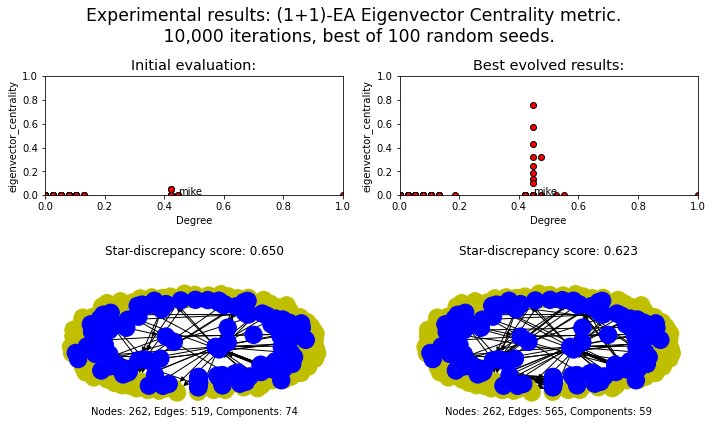

In [118]:
# set the best seed
np.random.seed(scores[scores['score'] == scores['score'].min()]['seed'])

# perform the evolution strategy (mu, lambda) search
iterations, best, score = es_plus(adj_matrix, objective, n_iter, mu, lam, centrality)

# Initial graph G
G = nx.from_pandas_adjacency(adj_matrix, create_using=nx.DiGraph)

# Optimised graph N
N = nx.from_pandas_adjacency(best, create_using=nx.DiGraph)

# plot results
fig3, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2,figsize=(10,6))
ax1.set_title('Initial evaluation:',fontsize='x-large')
ax2.set_title('Best evolved results:',fontsize='x-large')
plot_results(ax1,'u: mikeharrisontelia','u: dependabot[bot]', adj_matrix, centrality)
plot_results(ax2,'u: mikeharrisontelia','u: dependabot[bot]', best, centrality)
color_map = ['b' if node.startswith('u: ') else 'y' for node in G]
nx.draw(G, node_color=color_map, pos = pos, ax=ax3)
nx.draw(N, node_color=color_map, pos = pos, ax=ax4)
ax3.text(0.5,-0.1,f'Nodes: {nx.number_of_nodes(G)}, Edges: {nx.number_of_edges(G)}, Components: {nx.number_weakly_connected_components(G)}', ha='center', transform=ax3.transAxes)
ax4.text(0.5,-0.1,f'Nodes: {nx.number_of_nodes(N)}, Edges: {nx.number_of_edges(N)}, Components: {nx.number_weakly_connected_components(N)}', ha='center', transform=ax4.transAxes)
fig3.suptitle(f"Experimental results: ({lam}+{mu})-EA {str(centrality).split(' ')[1].replace('_', ' ').title()} metric. \n {n_iter:,} iterations, best of {seeds:,} random seeds.",fontsize='xx-large')
fig3.tight_layout()
fig3

In [119]:
# (1 + 1) katz centrality evaluation:

seeds, n_iter, mu, lam, centrality = 100, 10000, 1, 1, nx.katz_centrality

scores = find_seed(seeds, adj_matrix, objective, n_iter, mu, lam, centrality)
scores.sort_values('score')

100%|██████████| 100/100 [00:23<00:00,  4.26it/s]


,seed,iterations,score,nodes,edges,components
69,69,12,0.578626,262,550,57
82,82,5,0.580445,262,549,67
47,47,9,0.580870,262,541,62
43,43,8,0.581587,262,535,63
67,67,7,0.582104,262,537,64
...,...,...,...,...,...,...
53,53,0,0.588324,262,519,74
9,9,0,0.588324,262,519,74
59,59,0,0.588324,262,519,74
83,83,0,0.588324,262,519,74


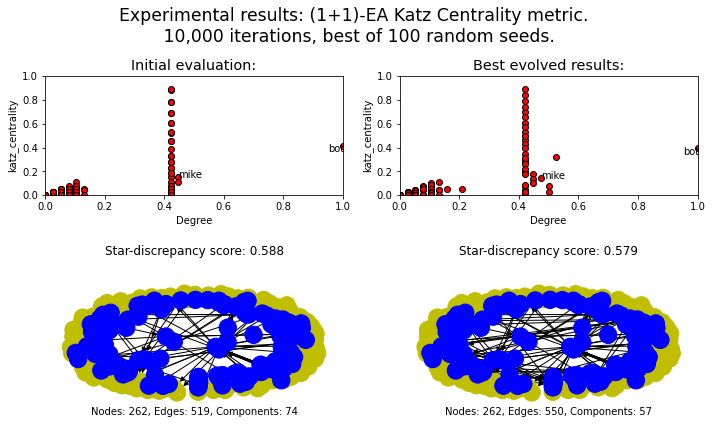

In [120]:
# set the best seed
np.random.seed(scores[scores['score'] == scores['score'].min()]['seed'])

# perform the evolution strategy (mu, lambda) search
iterations, best, score = es_plus(adj_matrix, objective, n_iter, mu, lam, centrality)

# Initial graph G
G = nx.from_pandas_adjacency(adj_matrix, create_using=nx.DiGraph)

# Optimised graph N
N = nx.from_pandas_adjacency(best, create_using=nx.DiGraph)

# plot results
fig4, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2,figsize=(10,6))
ax1.set_title('Initial evaluation:',fontsize='x-large')
ax2.set_title('Best evolved results:',fontsize='x-large')
plot_results(ax1,'u: mikeharrisontelia','u: dependabot[bot]', adj_matrix, centrality)
plot_results(ax2,'u: mikeharrisontelia','u: dependabot[bot]', best, centrality)
color_map = ['b' if node.startswith('u: ') else 'y' for node in G]
nx.draw(G, node_color=color_map, pos = pos, ax=ax3)
nx.draw(N, node_color=color_map, pos = pos, ax=ax4)
ax3.text(0.5,-0.1,f'Nodes: {nx.number_of_nodes(G)}, Edges: {nx.number_of_edges(G)}, Components: {nx.number_weakly_connected_components(G)}', ha='center', transform=ax3.transAxes)
ax4.text(0.5,-0.1,f'Nodes: {nx.number_of_nodes(N)}, Edges: {nx.number_of_edges(N)}, Components: {nx.number_weakly_connected_components(N)}', ha='center', transform=ax4.transAxes)
fig4.suptitle(f"Experimental results: ({lam}+{mu})-EA {str(centrality).split(' ')[1].replace('_', ' ').title()} metric. \n {n_iter:,} iterations, best of {seeds:,} random seeds.",fontsize='xx-large')
fig4.tight_layout()
fig4

In [121]:
# (1 + 1) pagerank evaluation:

seeds, n_iter, mu, lam, centrality = 100, 10000, 1, 1, nx.pagerank

scores = find_seed(seeds, adj_matrix, objective, n_iter, mu, lam, centrality)
scores.sort_values('score')

100%|██████████| 100/100 [00:17<00:00,  5.58it/s]


,seed,iterations,score,nodes,edges,components
43,43,8,0.616461,262,535,63
82,82,5,0.621719,262,549,67
44,44,9,0.621798,262,537,63
60,60,8,0.622144,262,532,64
67,67,7,0.623101,262,537,64
...,...,...,...,...,...,...
51,51,0,0.632000,262,519,74
79,79,0,0.632000,262,519,74
18,18,0,0.632000,262,519,74
7,7,0,0.632000,262,519,74


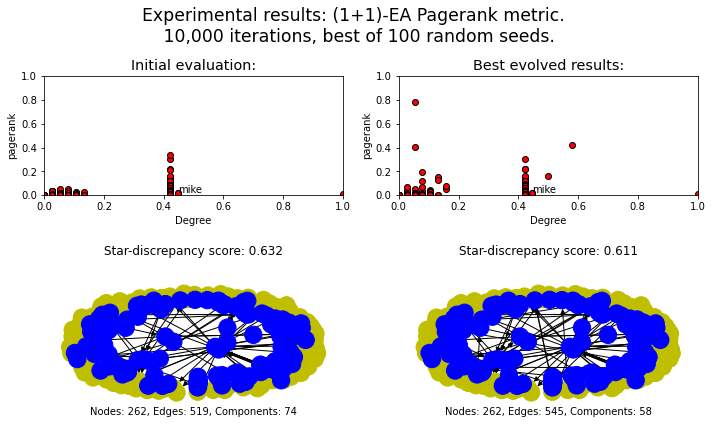

In [122]:
# set the best seed
np.random.seed(scores[scores['score'] == scores['score'].min()]['seed'])

# perform the evolution strategy (mu, lambda) search
iterations, best, score = es_plus(adj_matrix, objective, n_iter, mu, lam, centrality)

# Initial graph G
G = nx.from_pandas_adjacency(adj_matrix, create_using=nx.DiGraph)

# Optimised graph N
N = nx.from_pandas_adjacency(best, create_using=nx.DiGraph)

# plot results
fig5, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2,figsize=(10,6))
ax1.set_title('Initial evaluation:',fontsize='x-large')
ax2.set_title('Best evolved results:',fontsize='x-large')
plot_results(ax1,'u: mikeharrisontelia','u: dependabot[bot]', adj_matrix, centrality)
plot_results(ax2,'u: mikeharrisontelia','u: dependabot[bot]', best, centrality)
color_map = ['b' if node.startswith('u: ') else 'y' for node in G]
nx.draw(G, node_color=color_map, pos = pos, ax=ax3)
nx.draw(N, node_color=color_map, pos = pos, ax=ax4)
ax3.text(0.5,-0.1,f'Nodes: {nx.number_of_nodes(G)}, Edges: {nx.number_of_edges(G)}, Components: {nx.number_weakly_connected_components(G)}', ha='center', transform=ax3.transAxes)
ax4.text(0.5,-0.1,f'Nodes: {nx.number_of_nodes(N)}, Edges: {nx.number_of_edges(N)}, Components: {nx.number_weakly_connected_components(N)}', ha='center', transform=ax4.transAxes)
fig5.suptitle(f"Experimental results: ({lam}+{mu})-EA {str(centrality).split(' ')[1].replace('_', ' ').title()} metric. \n {n_iter:,} iterations, best of {seeds:,} random seeds.",fontsize='xx-large')
fig5.tight_layout()
fig5

In [123]:
with PdfPages('Single.pdf') as pdf:
    pdf.savefig(fig1)
    pdf.savefig(fig2)
    pdf.savefig(fig3)
    pdf.savefig(fig4)
    pdf.savefig(fig5)

## Experimental results:
### G = Connected graph
Add edges between connected components until end up with one weakly connected graph, i.e. a graph where all its nodes are connected in at least one direction.

In [138]:
G = nx.from_pandas_adjacency(adj_matrix, create_using=nx.DiGraph)
connected_components = list(nx.weakly_connected_components(G))

users_connected_components = list()
repos_connected_components = list()

for component in connected_components:

    users_aux = list()
    repos_aux = list()

    for node in component:
        if node.startswith('u: '):
            users_aux.append(node)
        else:
            repos_aux.append(node)

    users_connected_components.append(users_aux)
    repos_connected_components.append(repos_aux)

# Send first component to the last place:
repos_connected_components.append(repos_connected_components.pop(0))


for users, repos in zip(users_connected_components,repos_connected_components):
    user = random.choice(users)
    repo = random.choice(repos)
    G.add_edge(user, repo)
    G.add_edge(repo, user)

print(f'Is weakly connected\t\t\t = {nx.is_weakly_connected(G)}, \nNumber of weakly connected components\t = {nx.number_weakly_connected_components(G)}')

Is weakly connected			 = True, 
Number of weakly connected components	 = 1


In [139]:
connencted_adj_matrix = nx.to_pandas_adjacency(G)

In [140]:
# (1 + 1) betweeness centrality evaluation:

seeds, n_iter, mu, lam, centrality = 100, 10000, 1, 1, nx.betweenness_centrality

scores = find_seed(seeds, connencted_adj_matrix, objective, n_iter, mu, lam, centrality)
scores.sort_values('score')

100%|██████████| 100/100 [00:35<00:00,  2.78it/s]


,seed,iterations,score,nodes,edges,components
46,46,2,0.236480,262,787,1
63,63,2,0.254806,262,792,1
67,67,2,0.257618,262,787,1
78,78,4,0.264600,262,794,1
71,71,1,0.268799,262,788,1
...,...,...,...,...,...,...
73,73,0,0.324814,262,667,1
8,8,0,0.324814,262,667,1
3,3,0,0.324814,262,667,1
62,62,0,0.324814,262,667,1


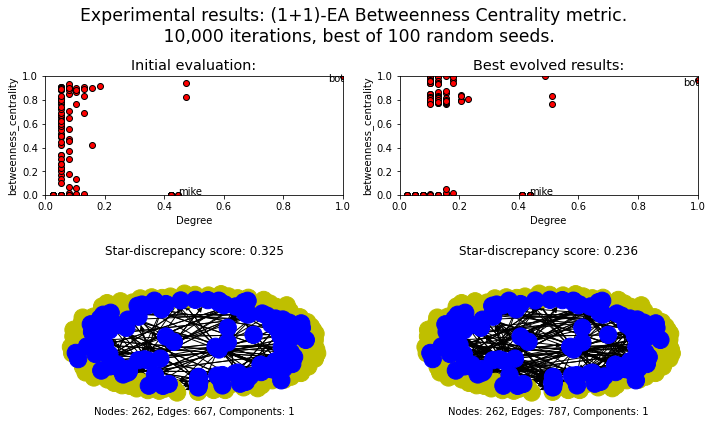

In [141]:
# set the best seed
np.random.seed(scores[scores['score'] == scores['score'].min()]['seed'])

# perform the evolution strategy (mu, lambda) search
iterations, best, score = es_plus(connencted_adj_matrix, objective, n_iter, mu, lam, centrality)

# Initial graph G
G = nx.from_pandas_adjacency(connencted_adj_matrix, create_using=nx.DiGraph)

# Optimised graph N
N = nx.from_pandas_adjacency(best, create_using=nx.DiGraph)

# plot results
fig1, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2,figsize=(10,6))
ax1.set_title('Initial evaluation:',fontsize='x-large')
ax2.set_title('Best evolved results:',fontsize='x-large')
plot_results(ax1,'u: mikeharrisontelia','u: dependabot[bot]', connencted_adj_matrix, centrality)
plot_results(ax2,'u: mikeharrisontelia','u: dependabot[bot]', best, centrality)
color_map = ['b' if node.startswith('u: ') else 'y' for node in G]
nx.draw(G, node_color=color_map, pos = pos, ax=ax3)
nx.draw(N, node_color=color_map, pos = pos, ax=ax4)
ax3.text(0.5,-0.1,f'Nodes: {nx.number_of_nodes(G)}, Edges: {nx.number_of_edges(G)}, Components: {nx.number_weakly_connected_components(G)}', ha='center', transform=ax3.transAxes)
ax4.text(0.5,-0.1,f'Nodes: {nx.number_of_nodes(N)}, Edges: {nx.number_of_edges(N)}, Components: {nx.number_weakly_connected_components(N)}', ha='center', transform=ax4.transAxes)
fig1.suptitle(f"Experimental results: ({lam}+{mu})-EA {str(centrality).split(' ')[1].replace('_', ' ').title()} metric. \n {n_iter:,} iterations, best of {seeds:,} random seeds.",fontsize='xx-large')
fig1.tight_layout()
fig1

In [142]:
# (1 + 1) closeness centrality evaluation:

seeds, n_iter, mu, lam, centrality = 100, 10000, 1, 1, nx.closeness_centrality

scores = find_seed(seeds, connencted_adj_matrix, objective, n_iter, mu, lam, centrality)
scores.sort_values('score')

100%|██████████| 100/100 [00:35<00:00,  2.78it/s]


,seed,iterations,score,nodes,edges,components
6,6,2,0.455496,262,787,1
19,19,11,0.505323,262,824,1
79,79,7,0.508023,262,819,1
82,82,6,0.510749,262,823,1
22,22,6,0.514263,262,797,1
...,...,...,...,...,...,...
85,85,0,0.546974,262,667,1
11,11,0,0.546974,262,667,1
91,91,0,0.546974,262,667,1
46,46,0,0.546974,262,667,1


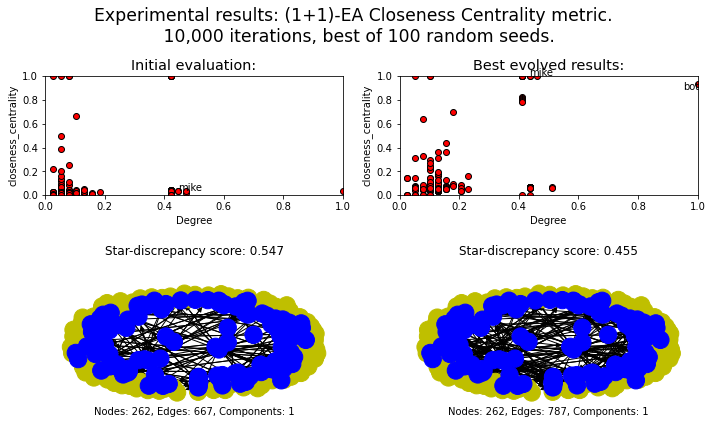

In [143]:
# set the best seed
np.random.seed(scores[scores['score'] == scores['score'].min()]['seed'])

# perform the evolution strategy (mu, lambda) search
iterations, best, score = es_plus(connencted_adj_matrix, objective, n_iter, mu, lam, centrality)

# Initial graph G
G = nx.from_pandas_adjacency(connencted_adj_matrix, create_using=nx.DiGraph)

# Optimised graph N
N = nx.from_pandas_adjacency(best, create_using=nx.DiGraph)

# plot results
fig2, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2,figsize=(10,6))
ax1.set_title('Initial evaluation:',fontsize='x-large')
ax2.set_title('Best evolved results:',fontsize='x-large')
plot_results(ax1,'u: mikeharrisontelia','u: dependabot[bot]', connencted_adj_matrix, centrality)
plot_results(ax2,'u: mikeharrisontelia','u: dependabot[bot]', best, centrality)
color_map = ['b' if node.startswith('u: ') else 'y' for node in G]
nx.draw(G, node_color=color_map, pos = pos, ax=ax3)
nx.draw(N, node_color=color_map, pos = pos, ax=ax4)
ax3.text(0.5,-0.1,f'Nodes: {nx.number_of_nodes(G)}, Edges: {nx.number_of_edges(G)}, Components: {nx.number_weakly_connected_components(G)}', ha='center', transform=ax3.transAxes)
ax4.text(0.5,-0.1,f'Nodes: {nx.number_of_nodes(N)}, Edges: {nx.number_of_edges(N)}, Components: {nx.number_weakly_connected_components(N)}', ha='center', transform=ax4.transAxes)
fig2.suptitle(f"Experimental results: ({lam}+{mu})-EA {str(centrality).split(' ')[1].replace('_', ' ').title()} metric. \n {n_iter:,} iterations, best of {seeds:,} random seeds.",fontsize='xx-large')
fig2.tight_layout()
fig2

In [144]:
# (1 + 1) eigenvector centrality evaluation:

seeds, n_iter, mu, lam, centrality = 100, 10000, 1, 1, nx.eigenvector_centrality

scores = find_seed(seeds, connencted_adj_matrix, objective, n_iter, mu, lam, centrality)
scores.sort_values('score')

100%|██████████| 100/100 [03:12<00:00,  1.93s/it]


,seed,iterations,score,nodes,edges,components
82,82,16,0.564780,262,852,1
50,50,20,0.571282,262,843,1
69,69,12,0.575827,262,825,1
47,47,9,0.576368,262,815,1
17,17,5,0.577039,262,815,1
...,...,...,...,...,...,...
87,87,2,0.589349,262,790,1
84,84,3,0.589478,262,792,1
53,53,1,0.590027,262,788,1
7,7,1,0.590027,262,788,1


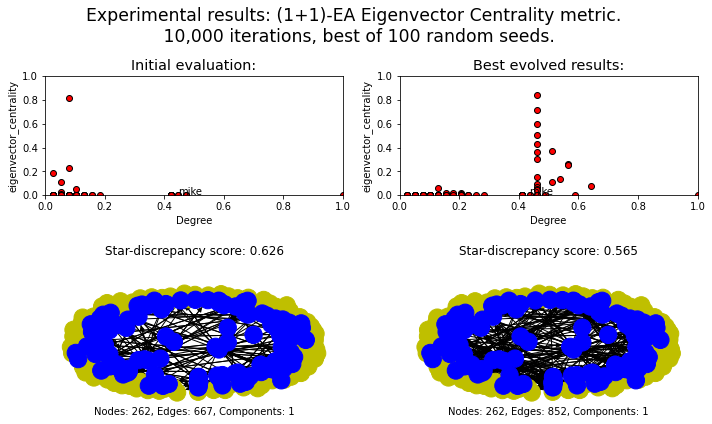

In [145]:
# set the best seed
np.random.seed(scores[scores['score'] == scores['score'].min()]['seed'])

# perform the evolution strategy (mu, lambda) search
iterations, best, score = es_plus(connencted_adj_matrix, objective, n_iter, mu, lam, centrality)

# Initial graph G
G = nx.from_pandas_adjacency(connencted_adj_matrix, create_using=nx.DiGraph)

# Optimised graph N
N = nx.from_pandas_adjacency(best, create_using=nx.DiGraph)

# plot results
fig3, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2,figsize=(10,6))
ax1.set_title('Initial evaluation:',fontsize='x-large')
ax2.set_title('Best evolved results:',fontsize='x-large')
plot_results(ax1,'u: mikeharrisontelia','u: dependabot[bot]', connencted_adj_matrix, centrality)
plot_results(ax2,'u: mikeharrisontelia','u: dependabot[bot]', best, centrality)
color_map = ['b' if node.startswith('u: ') else 'y' for node in G]
nx.draw(G, node_color=color_map, pos = pos, ax=ax3)
nx.draw(N, node_color=color_map, pos = pos, ax=ax4)
ax3.text(0.5,-0.1,f'Nodes: {nx.number_of_nodes(G)}, Edges: {nx.number_of_edges(G)}, Components: {nx.number_weakly_connected_components(G)}', ha='center', transform=ax3.transAxes)
ax4.text(0.5,-0.1,f'Nodes: {nx.number_of_nodes(N)}, Edges: {nx.number_of_edges(N)}, Components: {nx.number_weakly_connected_components(N)}', ha='center', transform=ax4.transAxes)
fig3.suptitle(f"Experimental results: ({lam}+{mu})-EA {str(centrality).split(' ')[1].replace('_', ' ').title()} metric. \n {n_iter:,} iterations, best of {seeds:,} random seeds.",fontsize='xx-large')
fig3.tight_layout()
fig3

In [146]:
# (1 + 1) katz centrality evaluation:

seeds, n_iter, mu, lam, centrality = 100, 10000, 1, 1, nx.katz_centrality

scores = find_seed(seeds, connencted_adj_matrix, objective, n_iter, mu, lam, centrality)
scores.sort_values('score')

100%|██████████| 100/100 [00:33<00:00,  2.97it/s]


,seed,iterations,score,nodes,edges,components
82,82,14,0.508184,262,846,1
79,79,7,0.514407,262,821,1
47,47,9,0.515484,262,815,1
67,67,7,0.515938,262,812,1
43,43,8,0.516255,262,809,1
...,...,...,...,...,...,...
87,87,2,0.527916,262,790,1
84,84,3,0.528004,262,792,1
53,53,1,0.528374,262,788,1
7,7,1,0.528403,262,788,1


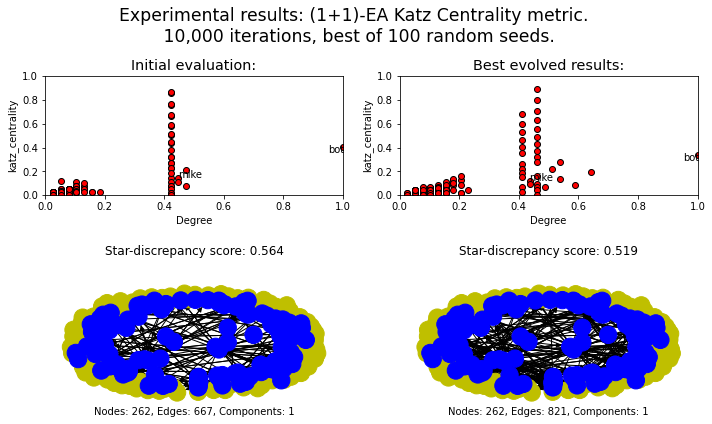

In [147]:
# set the best seed
np.random.seed(scores[scores['score'] == scores['score'].min()]['seed'])

# perform the evolution strategy (mu, lambda) search
iterations, best, score = es_plus(connencted_adj_matrix, objective, n_iter, mu, lam, centrality)

# Initial graph G
G = nx.from_pandas_adjacency(connencted_adj_matrix, create_using=nx.DiGraph)

# Optimised graph N
N = nx.from_pandas_adjacency(best, create_using=nx.DiGraph)

# plot results
fig4, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2,figsize=(10,6))
ax1.set_title('Initial evaluation:',fontsize='x-large')
ax2.set_title('Best evolved results:',fontsize='x-large')
plot_results(ax1,'u: mikeharrisontelia','u: dependabot[bot]', connencted_adj_matrix, centrality)
plot_results(ax2,'u: mikeharrisontelia','u: dependabot[bot]', best, centrality)
color_map = ['b' if node.startswith('u: ') else 'y' for node in G]
nx.draw(G, node_color=color_map, pos = pos, ax=ax3)
nx.draw(N, node_color=color_map, pos = pos, ax=ax4)
ax3.text(0.5,-0.1,f'Nodes: {nx.number_of_nodes(G)}, Edges: {nx.number_of_edges(G)}, Components: {nx.number_weakly_connected_components(G)}', ha='center', transform=ax3.transAxes)
ax4.text(0.5,-0.1,f'Nodes: {nx.number_of_nodes(N)}, Edges: {nx.number_of_edges(N)}, Components: {nx.number_weakly_connected_components(N)}', ha='center', transform=ax4.transAxes)
fig4.suptitle(f"Experimental results: ({lam}+{mu})-EA {str(centrality).split(' ')[1].replace('_', ' ').title()} metric. \n {n_iter:,} iterations, best of {seeds:,} random seeds.",fontsize='xx-large')
fig4.tight_layout()
fig4

In [148]:
# (1 + 1) pagerank evaluation:

seeds, n_iter, mu, lam, centrality = 100, 10000, 1, 1, nx.pagerank

scores = find_seed(seeds, connencted_adj_matrix, objective, n_iter, mu, lam, centrality)
scores.sort_values('score')

100%|██████████| 100/100 [00:11<00:00,  8.81it/s]


,seed,iterations,score,nodes,edges,components
0,0,0,0.469206,262,667,1
72,72,0,0.469206,262,667,1
71,71,0,0.469206,262,667,1
70,70,0,0.469206,262,667,1
69,69,1,0.469206,262,667,1
...,...,...,...,...,...,...
28,28,0,0.469206,262,667,1
27,27,0,0.469206,262,667,1
26,26,0,0.469206,262,667,1
36,36,0,0.469206,262,667,1


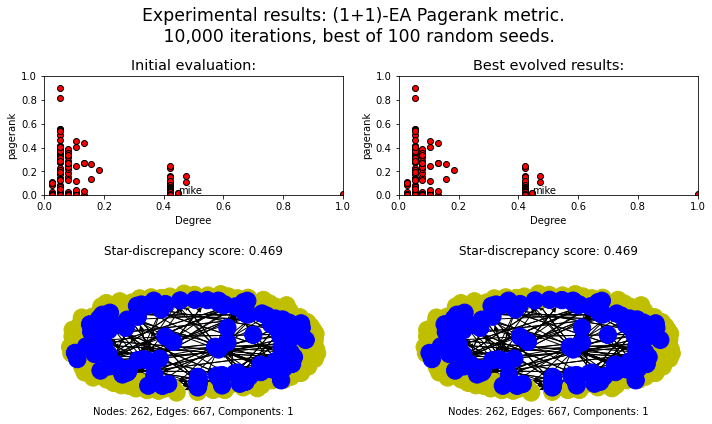

In [149]:
# set the best seed
np.random.seed(scores[scores['score'] == scores['score'].min()]['seed'])

# perform the evolution strategy (mu, lambda) search
iterations, best, score = es_plus(connencted_adj_matrix, objective, n_iter, mu, lam, centrality)

# Initial graph G
G = nx.from_pandas_adjacency(connencted_adj_matrix, create_using=nx.DiGraph)

# Optimised graph N
N = nx.from_pandas_adjacency(best, create_using=nx.DiGraph)

# plot results
fig5, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2,figsize=(10,6))
ax1.set_title('Initial evaluation:',fontsize='x-large')
ax2.set_title('Best evolved results:',fontsize='x-large')
plot_results(ax1,'u: mikeharrisontelia','u: dependabot[bot]', connencted_adj_matrix, centrality)
plot_results(ax2,'u: mikeharrisontelia','u: dependabot[bot]', best, centrality)
color_map = ['b' if node.startswith('u: ') else 'y' for node in G]
nx.draw(G, node_color=color_map, pos = pos, ax=ax3)
nx.draw(N, node_color=color_map, pos = pos, ax=ax4)
ax3.text(0.5,-0.1,f'Nodes: {nx.number_of_nodes(G)}, Edges: {nx.number_of_edges(G)}, Components: {nx.number_weakly_connected_components(G)}', ha='center', transform=ax3.transAxes)
ax4.text(0.5,-0.1,f'Nodes: {nx.number_of_nodes(N)}, Edges: {nx.number_of_edges(N)}, Components: {nx.number_weakly_connected_components(N)}', ha='center', transform=ax4.transAxes)
fig5.suptitle(f"Experimental results: ({lam}+{mu})-EA {str(centrality).split(' ')[1].replace('_', ' ').title()} metric. \n {n_iter:,} iterations, best of {seeds:,} random seeds.",fontsize='xx-large')
fig5.tight_layout()
fig5

In [150]:
with PdfPages('Connected.pdf') as pdf:
    pdf.savefig(fig1)
    pdf.savefig(fig2)
    pdf.savefig(fig3)
    pdf.savefig(fig4)
    pdf.savefig(fig5)

## Experimental results:
### Connected graph and increased population

In [152]:
# (1 + 20) betweeness centrality evaluation:

seeds, n_iter, mu, lam, centrality = 10, 10000, 1, 20, nx.betweenness_centrality

scores = find_seed(seeds, connencted_adj_matrix, objective, n_iter, mu, lam, centrality)
scores.sort_values('score')

100%|██████████| 10/10 [02:50<00:00, 17.10s/it]


,seed,iterations,score,nodes,edges,components
1,1,12,0.218159,262,815,1
9,9,4,0.222603,262,798,1
5,5,4,0.242298,262,807,1
0,0,11,0.242510,262,799,1
4,4,6,0.242629,262,816,1
7,7,12,0.251856,262,805,1
6,6,8,0.254173,262,796,2
2,2,20,0.268208,262,817,1
8,8,2,0.298168,262,794,1
3,3,2,0.306852,262,789,1


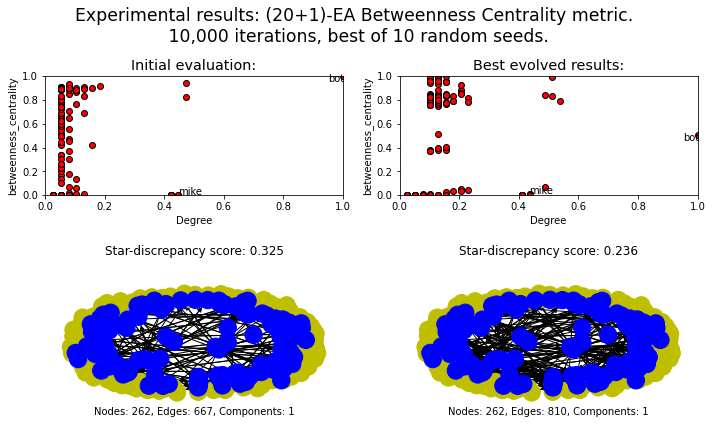

In [153]:
# set the best seed
np.random.seed(scores[scores['score'] == scores['score'].min()]['seed'])

# perform the evolution strategy (mu, lambda) search
iterations, best, score = es_plus(connencted_adj_matrix, objective, n_iter, mu, lam, centrality)

# Initial graph G
G = nx.from_pandas_adjacency(connencted_adj_matrix, create_using=nx.DiGraph)

# Optimised graph N
N = nx.from_pandas_adjacency(best, create_using=nx.DiGraph)

# plot results
fig1, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2,figsize=(10,6))
ax1.set_title('Initial evaluation:',fontsize='x-large')
ax2.set_title('Best evolved results:',fontsize='x-large')
plot_results(ax1,'u: mikeharrisontelia','u: dependabot[bot]', connencted_adj_matrix, centrality)
plot_results(ax2,'u: mikeharrisontelia','u: dependabot[bot]', best, centrality)
color_map = ['b' if node.startswith('u: ') else 'y' for node in G]
nx.draw(G, node_color=color_map, pos = pos, ax=ax3)
nx.draw(N, node_color=color_map, pos = pos, ax=ax4)
ax3.text(0.5,-0.1,f'Nodes: {nx.number_of_nodes(G)}, Edges: {nx.number_of_edges(G)}, Components: {nx.number_weakly_connected_components(G)}', ha='center', transform=ax3.transAxes)
ax4.text(0.5,-0.1,f'Nodes: {nx.number_of_nodes(N)}, Edges: {nx.number_of_edges(N)}, Components: {nx.number_weakly_connected_components(N)}', ha='center', transform=ax4.transAxes)
fig1.suptitle(f"Experimental results: ({lam}+{mu})-EA {str(centrality).split(' ')[1].replace('_', ' ').title()} metric. \n {n_iter:,} iterations, best of {seeds:,} random seeds.",fontsize='xx-large')
fig1.tight_layout()
fig1

In [154]:
# (1 + 20) closeness centrality evaluation:

seeds, n_iter, mu, lam, centrality = 10, 10000, 1, 20, nx.closeness_centrality

scores = find_seed(seeds, connencted_adj_matrix, objective, n_iter, mu, lam, centrality)
scores.sort_values('score')

100%|██████████| 10/10 [37:14<00:00, 223.50s/it]


,seed,iterations,score,nodes,edges,components
5,5,208,0.076339,262,2055,2
7,7,234,0.081567,262,2162,2
3,3,202,0.089258,262,2103,2
0,0,181,0.112103,262,1835,2
9,9,184,0.117420,262,1828,1
1,1,190,0.121754,262,1853,1
2,2,143,0.142959,262,1673,2
8,8,172,0.146992,262,1761,2
4,4,180,0.185451,262,1548,2
6,6,144,0.196301,262,1349,2


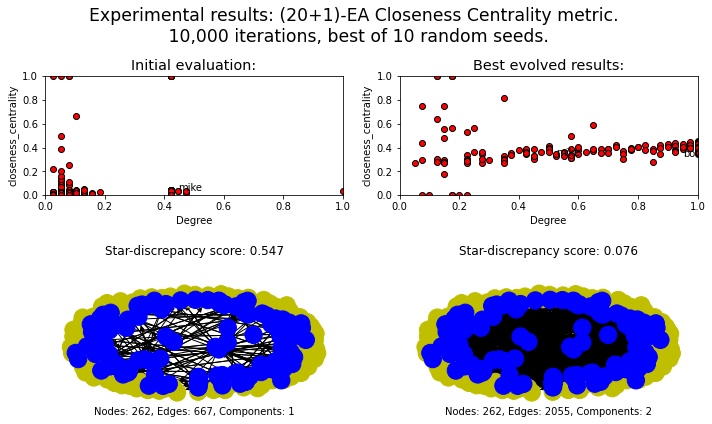

In [155]:
# set the best seed
np.random.seed(scores[scores['score'] == scores['score'].min()]['seed'])

# perform the evolution strategy (mu, lambda) search
iterations, best, score = es_plus(connencted_adj_matrix, objective, n_iter, mu, lam, centrality)

# Initial graph G
G = nx.from_pandas_adjacency(connencted_adj_matrix, create_using=nx.DiGraph)

# Optimised graph N
N = nx.from_pandas_adjacency(best, create_using=nx.DiGraph)

# plot results
fig2, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2,figsize=(10,6))
ax1.set_title('Initial evaluation:',fontsize='x-large')
ax2.set_title('Best evolved results:',fontsize='x-large')
plot_results(ax1,'u: mikeharrisontelia','u: dependabot[bot]', connencted_adj_matrix, centrality)
plot_results(ax2,'u: mikeharrisontelia','u: dependabot[bot]', best, centrality)
color_map = ['b' if node.startswith('u: ') else 'y' for node in G]
nx.draw(G, node_color=color_map, pos = pos, ax=ax3)
nx.draw(N, node_color=color_map, pos = pos, ax=ax4)
ax3.text(0.5,-0.1,f'Nodes: {nx.number_of_nodes(G)}, Edges: {nx.number_of_edges(G)}, Components: {nx.number_weakly_connected_components(G)}', ha='center', transform=ax3.transAxes)
ax4.text(0.5,-0.1,f'Nodes: {nx.number_of_nodes(N)}, Edges: {nx.number_of_edges(N)}, Components: {nx.number_weakly_connected_components(N)}', ha='center', transform=ax4.transAxes)
fig2.suptitle(f"Experimental results: ({lam}+{mu})-EA {str(centrality).split(' ')[1].replace('_', ' ').title()} metric. \n {n_iter:,} iterations, best of {seeds:,} random seeds.",fontsize='xx-large')
fig2.tight_layout()
fig2

In [156]:
# (1 + 20) eigenvector centrality evaluation:

seeds, n_iter, mu, lam, centrality = 10, 10000, 1, 20, nx.eigenvector_centrality

scores = find_seed(seeds, connencted_adj_matrix, objective, n_iter, mu, lam, centrality)
scores.sort_values('score')

100%|██████████| 10/10 [27:04<00:00, 162.50s/it]


,seed,iterations,score,nodes,edges,components
9,9,235,0.030625,262,2063,1
7,7,220,0.032009,262,1933,1
3,3,239,0.032224,262,2179,1
2,2,225,0.037492,262,2357,1
1,1,221,0.041269,262,2093,1
5,5,230,0.044781,262,2121,1
0,0,194,0.075315,262,2025,2
8,8,183,0.104685,262,1706,2
6,6,171,0.124255,262,1633,2
4,4,139,0.145238,262,1424,2


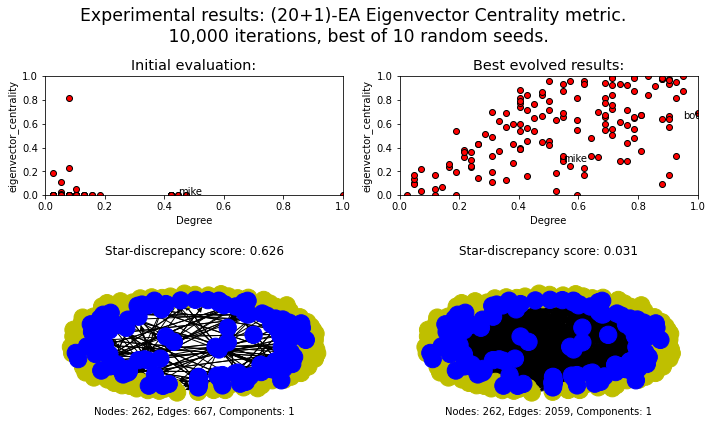

In [157]:
# set the best seed
np.random.seed(scores[scores['score'] == scores['score'].min()]['seed'])

# perform the evolution strategy (mu, lambda) search
iterations, best, score = es_plus(connencted_adj_matrix, objective, n_iter, mu, lam, centrality)

# Initial graph G
G = nx.from_pandas_adjacency(connencted_adj_matrix, create_using=nx.DiGraph)

# Optimised graph N
N = nx.from_pandas_adjacency(best, create_using=nx.DiGraph)

# plot results
fig3, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2,figsize=(10,6))
ax1.set_title('Initial evaluation:',fontsize='x-large')
ax2.set_title('Best evolved results:',fontsize='x-large')
plot_results(ax1,'u: mikeharrisontelia','u: dependabot[bot]', connencted_adj_matrix, centrality)
plot_results(ax2,'u: mikeharrisontelia','u: dependabot[bot]', best, centrality)
color_map = ['b' if node.startswith('u: ') else 'y' for node in G]
nx.draw(G, node_color=color_map, pos = pos, ax=ax3)
nx.draw(N, node_color=color_map, pos = pos, ax=ax4)
ax3.text(0.5,-0.1,f'Nodes: {nx.number_of_nodes(G)}, Edges: {nx.number_of_edges(G)}, Components: {nx.number_weakly_connected_components(G)}', ha='center', transform=ax3.transAxes)
ax4.text(0.5,-0.1,f'Nodes: {nx.number_of_nodes(N)}, Edges: {nx.number_of_edges(N)}, Components: {nx.number_weakly_connected_components(N)}', ha='center', transform=ax4.transAxes)
fig3.suptitle(f"Experimental results: ({lam}+{mu})-EA {str(centrality).split(' ')[1].replace('_', ' ').title()} metric. \n {n_iter:,} iterations, best of {seeds:,} random seeds.",fontsize='xx-large')
fig3.tight_layout()
fig3

In [160]:
# (1 + 1) katz centrality evaluation:

seeds, n_iter, mu, lam, centrality = 10, 10000, 1, 20, nx.katz_centrality

scores = find_seed(seeds, connencted_adj_matrix, objective, n_iter, mu, lam, centrality)
scores.sort_values('score')

100%|██████████| 10/10 [52:30<00:00, 315.08s/it]


,seed,iterations,score,nodes,edges,components
2,2,187,0.031568,262,1905,1
3,3,208,0.031883,262,1970,1
1,1,192,0.034875,262,1964,1
5,5,207,0.038015,262,1923,1
8,8,194,0.041998,262,1874,2
7,7,186,0.044446,262,1868,2
4,4,197,0.045308,262,1829,2
0,0,164,0.046646,262,1746,2
6,6,177,0.050455,262,1806,2
9,9,169,0.051581,262,1741,1


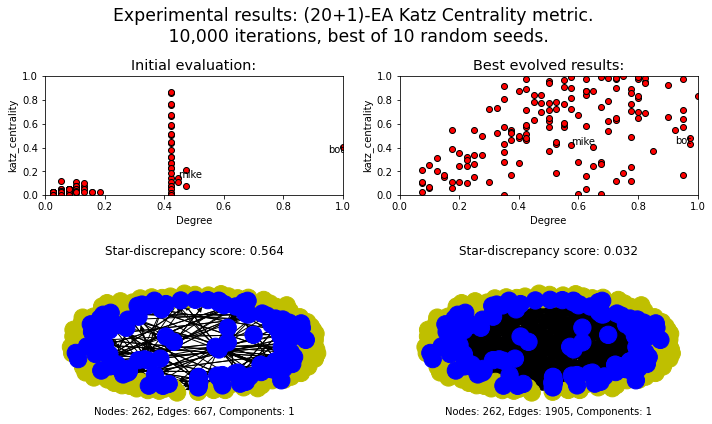

In [161]:
# set the best seed
np.random.seed(scores[scores['score'] == scores['score'].min()]['seed'])

# perform the evolution strategy (mu, lambda) search
iterations, best, score = es_plus(connencted_adj_matrix, objective, n_iter, mu, lam, centrality)

# Initial graph G
G = nx.from_pandas_adjacency(connencted_adj_matrix, create_using=nx.DiGraph)

# Optimised graph N
N = nx.from_pandas_adjacency(best, create_using=nx.DiGraph)

# plot results
fig4, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2,figsize=(10,6))
ax1.set_title('Initial evaluation:',fontsize='x-large')
ax2.set_title('Best evolved results:',fontsize='x-large')
plot_results(ax1,'u: mikeharrisontelia','u: dependabot[bot]', connencted_adj_matrix, centrality)
plot_results(ax2,'u: mikeharrisontelia','u: dependabot[bot]', best, centrality)
color_map = ['b' if node.startswith('u: ') else 'y' for node in G]
nx.draw(G, node_color=color_map, pos = pos, ax=ax3)
nx.draw(N, node_color=color_map, pos = pos, ax=ax4)
ax3.text(0.5,-0.1,f'Nodes: {nx.number_of_nodes(G)}, Edges: {nx.number_of_edges(G)}, Components: {nx.number_weakly_connected_components(G)}', ha='center', transform=ax3.transAxes)
ax4.text(0.5,-0.1,f'Nodes: {nx.number_of_nodes(N)}, Edges: {nx.number_of_edges(N)}, Components: {nx.number_weakly_connected_components(N)}', ha='center', transform=ax4.transAxes)
fig4.suptitle(f"Experimental results: ({lam}+{mu})-EA {str(centrality).split(' ')[1].replace('_', ' ').title()} metric. \n {n_iter:,} iterations, best of {seeds:,} random seeds.",fontsize='xx-large')
fig4.tight_layout()
fig4

In [162]:
# (1 + 1) pagerank evaluation:

seeds, n_iter, mu, lam, centrality = 10, 10000, 1, 20, nx.pagerank

scores = find_seed(seeds, connencted_adj_matrix, objective, n_iter, mu, lam, centrality)
scores.sort_values('score')

100%|██████████| 10/10 [00:09<00:00,  1.02it/s]


,seed,iterations,score,nodes,edges,components
0,0,0,0.469206,262,667,1
1,1,0,0.469206,262,667,1
2,2,0,0.469206,262,667,1
3,3,0,0.469206,262,667,1
4,4,0,0.469206,262,667,1
5,5,0,0.469206,262,667,1
6,6,0,0.469206,262,667,1
7,7,0,0.469206,262,667,1
8,8,0,0.469206,262,667,1
9,9,0,0.469206,262,667,1


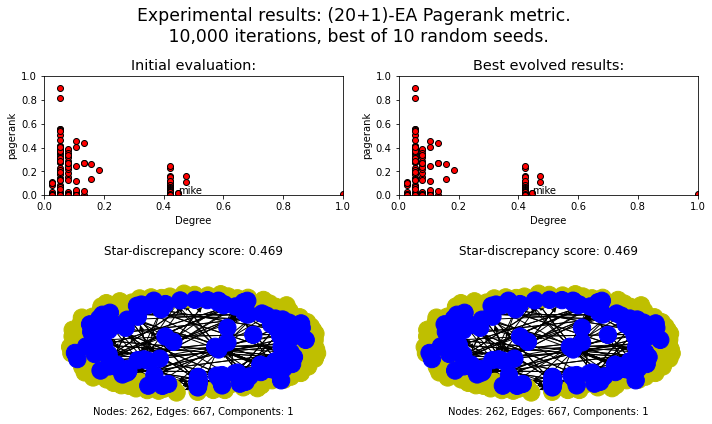

In [163]:
# set the best seed
np.random.seed(scores[scores['score'] == scores['score'].min()]['seed'])

# perform the evolution strategy (mu, lambda) search
iterations, best, score = es_plus(connencted_adj_matrix, objective, n_iter, mu, lam, centrality)

# Initial graph G
G = nx.from_pandas_adjacency(connencted_adj_matrix, create_using=nx.DiGraph)

# Optimised graph N
N = nx.from_pandas_adjacency(best, create_using=nx.DiGraph)

# plot results
fig5, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2,figsize=(10,6))
ax1.set_title('Initial evaluation:',fontsize='x-large')
ax2.set_title('Best evolved results:',fontsize='x-large')
plot_results(ax1,'u: mikeharrisontelia','u: dependabot[bot]', connencted_adj_matrix, centrality)
plot_results(ax2,'u: mikeharrisontelia','u: dependabot[bot]', best, centrality)
color_map = ['b' if node.startswith('u: ') else 'y' for node in G]
nx.draw(G, node_color=color_map, pos = pos, ax=ax3)
nx.draw(N, node_color=color_map, pos = pos, ax=ax4)
ax3.text(0.5,-0.1,f'Nodes: {nx.number_of_nodes(G)}, Edges: {nx.number_of_edges(G)}, Components: {nx.number_weakly_connected_components(G)}', ha='center', transform=ax3.transAxes)
ax4.text(0.5,-0.1,f'Nodes: {nx.number_of_nodes(N)}, Edges: {nx.number_of_edges(N)}, Components: {nx.number_weakly_connected_components(N)}', ha='center', transform=ax4.transAxes)
fig5.suptitle(f"Experimental results: ({lam}+{mu})-EA {str(centrality).split(' ')[1].replace('_', ' ').title()} metric. \n {n_iter:,} iterations, best of {seeds:,} random seeds.",fontsize='xx-large')
fig5.tight_layout()
fig5

In [164]:
with PdfPages('Population.pdf') as pdf:
    pdf.savefig(fig1)
    pdf.savefig(fig2)
    pdf.savefig(fig3)
    pdf.savefig(fig4)
    pdf.savefig(fig5)